In [1]:
import json
import math
import pickle
import sys
import threading
import time
import traceback
from collections import defaultdict
from concurrent.futures.thread import ThreadPoolExecutor
import numpy as np
from elote import EloCompetitor
from katrain.core.constants import (
    AI_LOCAL,
    AI_RANK,
    AI_TENUKI,
    AI_WEIGHTED,
    AI_PICK,
    AI_TERRITORY,
    AI_POLICY,
)

from settings import Logger
import matplotlib.pyplot as plt

[INFO   ] [Logger      ] Record log in C:\Users\sande\.kivy\logs\kivy_20-07-04_62.txt
[INFO   ] [deps        ] Successfully imported "kivy_deps.gstreamer" 0.1.17
[INFO   ] [deps        ] Successfully imported "kivy_deps.angle" 0.2.0
[INFO   ] [deps        ] Successfully imported "kivy_deps.glew" 0.2.0
[INFO   ] [deps        ] Successfully imported "kivy_deps.sdl2" 0.2.0
[INFO   ] [Kivy        ] v2.0.0rc2, git-78fb93b, 20200429
[INFO   ] [Kivy        ] Installed at "C:\Users\sande\Anaconda3\lib\site-packages\kivy\__init__.py"
[INFO   ] [Python      ] v3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
[INFO   ] [Python      ] Interpreter at "C:\Users\sande\Anaconda3\python.exe"


In [2]:
DB_FILENAME = "tournament_ai_performance.pickle"
class AI:
    def fix_settings(self):
        pass

try:
    with open(DB_FILENAME, "rb") as f:
        ai_database_loaded, all_results = pickle.load(f)
        ai_database = []
        for ai in ai_database_loaded:
            try:
                ai.fix_settings()  # update as required
                ai_database.append(ai)
            except Exception as e:
                print("Error loading AI", ai.strategy,e)
except FileNotFoundError:
    ai_database = []
    all_results = []

In [3]:
from sklearn.linear_model import LinearRegression
ranked = [ai for ai in ai_database if ai.strategy==AI_RANK]
calibrate = [ai for ai in ai_database if ai.strategy==AI_WEIGHTED]
policy = [ai for ai in ai_database if ai.strategy==AI_POLICY and ai.ai_settings['opening_moves']==0][0]

kyu_elo = [(r.ai_settings['kyu_rank'],r.elo_comp.rating) for r in ranked]
#kyu_elo.append( (-5,policy.elo_comp.rating) ) # policy ~5d
kyu_elo = sorted(kyu_elo)
kyu,elo = zip(*kyu_elo)

wt_elo =  [([r.ai_settings['weaken_fac'],-math.log(r.ai_settings['lower_bound']),1-r.ai_settings.get('pick_override',1)],r.elo_comp.rating) for r in calibrate]

x,y = zip(*wt_elo)
reg = LinearRegression().fit(x, y)

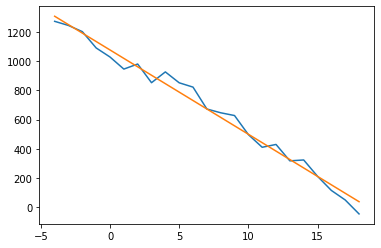

In [4]:
kyu2 = np.array(kyu)[:,np.newaxis]
reg = LinearRegression().fit(kyu2,elo)
plt.plot(kyu,elo,kyu,reg.predict(kyu2))

In [5]:
list(zip(kyu,reg.predict(kyu2)))

[(-4, 1306.2743633164778),
 (-3, 1248.6877655741948),
 (-2, 1191.101167831912),
 (-1, 1133.5145700896292),
 (0, 1075.9279723473464),
 (1, 1018.3413746050636),
 (2, 960.7547768627808),
 (3, 903.168179120498),
 (4, 845.5815813782152),
 (5, 787.9949836359324),
 (6, 730.4083858936496),
 (7, 672.8217881513667),
 (8, 615.235190409084),
 (9, 557.6485926668012),
 (10, 500.06199492451833),
 (11, 442.4753971822355),
 (12, 384.88879943995266),
 (13, 327.30220169766983),
 (14, 269.7156039553871),
 (15, 212.12900621310428),
 (16, 154.54240847082144),
 (17, 96.95581072853861),
 (18, 39.36921298625589)]

In [5]:
reg.predict(x)

array([1402.52138477, 1131.0916944 ,  995.37684921,  859.66200402,
        723.94715884,  588.23231365,  452.51746846])

In [6]:
y

(1424.4687011700541,
 1144.2851969464448,
 983.473460365626,
 849.2779807201654,
 683.2503739146116,
 528.7927812269777,
 539.8003790064159)

In [7]:
for ai in sorted(ai_database,key=lambda a:-a.elo_comp.rating):
    print(ai.elo_comp.rating,'\t',ai.name)

1862.4755993496708 	 ai:p:local(pick_frac=0.75,pick_n=50)
1810.7581765529053 	 ai:policy(opening_moves=0)
1808.1013445280687 	 ai:p:tenuki(pick_frac=1.0,pick_n=5)
1806.016528465102 	 ai:p:local(pick_frac=1.0,pick_n=50)
1776.9993959697324 	 ai:p:tenuki(pick_frac=1.0,pick_n=50)
1774.6576877746747 	 ai:p:territory(pick_frac=1.0,pick_n=5)
1771.7457599478712 	 ai:p:territory(pick_frac=1.0,pick_n=0)
1754.5176666496104 	 ai:p:local(pick_frac=1.0,pick_n=0)
1753.1288791509307 	 ai:p:tenuki(pick_frac=1.0,pick_n=25)
1742.8293951807038 	 ai:p:local(pick_frac=1.0,pick_n=5)
1735.035287819561 	 ai:p:territory(pick_frac=1.0,pick_n=50)
1724.2686693543678 	 ai:p:tenuki(pick_frac=1.0,pick_n=0)
1723.7260106746908 	 ai:p:territory(pick_frac=1.0,pick_n=10)
1718.5697631470948 	 ai:p:tenuki(pick_frac=1.0,pick_n=15)
1715.1999921287709 	 ai:p:local(pick_frac=1.0,pick_n=10)
1702.1601442041158 	 ai:p:local(pick_frac=1.0,pick_n=25)
1685.7506704792147 	 ai:p:local(pick_frac=0.75,pick_n=5)
1683.426243648616 	 ai:p:t

In [10]:
calibrate_d = {ai.ai_settings['kyu_rank']:ai for ai in ai_database if ai.strategy==AI_RANK}

In [13]:
y = sorted(calibrate_d.items(),key=lambda kv:kv[0])

[(-4, <__main__.AI at 0x7fe6a456b5f8>),
 (-3, <__main__.AI at 0x7fe6cb6525c0>),
 (-2, <__main__.AI at 0x7fe6a456b668>),
 (-1, <__main__.AI at 0x7fe6cb652550>),
 (0, <__main__.AI at 0x7fe6a456b6d8>),
 (1, <__main__.AI at 0x7fe6a456b748>),
 (2, <__main__.AI at 0x7fe6cb6524e0>),
 (3, <__main__.AI at 0x7fe6a456b7b8>),
 (4, <__main__.AI at 0x7fe6c8384470>),
 (5, <__main__.AI at 0x7fe6a456b828>),
 (6, <__main__.AI at 0x7fe6cb652470>),
 (7, <__main__.AI at 0x7fe6a456b898>),
 (8, <__main__.AI at 0x7fe6cb652400>),
 (9, <__main__.AI at 0x7fe6a456b908>),
 (10, <__main__.AI at 0x7fe6cb652390>),
 (11, <__main__.AI at 0x7fe6a456b978>),
 (12, <__main__.AI at 0x7fe6a456b9e8>),
 (13, <__main__.AI at 0x7fe6a456ba58>),
 (14, <__main__.AI at 0x7fe6cb652320>),
 (15, <__main__.AI at 0x7fe6a456bac8>),
 (16, <__main__.AI at 0x7fe6a456bb38>),
 (17, <__main__.AI at 0x7fe6a456bba8>),
 (18, <__main__.AI at 0x7fe6cb652160>)]